In [1]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import LeavePGroupsOut
from sklearn.preprocessing import StandardScaler
import scipy.io as scio
gpu_ok = tf.test.is_gpu_available()
print("tf version:", tf.__version__)
print("use GPU", gpu_ok)

tf version: 2.0.0
use GPU True


### 获取数据

In [2]:
initial_RAT_Control_Pus_48h_9 = scio.loadmat("../毕设/数据集/sensor大鼠数据/rat_data/data4/RAT_Control_Pus_48h_9.mat")
initial_RAT_Control_Pus_48h_9 = initial_RAT_Control_Pus_48h_9["RAT_Control_Pus_48h_9"]

initial_RAT_Ecoli_Pus_48h_12 = scio.loadmat("../毕设/数据集/sensor大鼠数据/rat_data/data4/RAT_Ecoli_Pus_48h_12.mat")
initial_RAT_Ecoli_Pus_48h_12 = initial_RAT_Ecoli_Pus_48h_12["RAT_Ecoli_Pus_48h_12"]

initial_RAT_Parug_Pus_48h_10 = scio.loadmat("../毕设/数据集/sensor大鼠数据/rat_data/data4/RAT_Parug_Pus_48h_10.mat")
initial_RAT_Parug_Pus_48h_10 = initial_RAT_Parug_Pus_48h_10["RAT_Parug_Pus_48h_10"]

initial_RAT_Saureus_Pus_48h_10 = scio.loadmat("../毕设/数据集/sensor大鼠数据/rat_data/data4/RAT_Saureus_Pus_48h_10.mat")
initial_RAT_Saureus_Pus_48h_10 = initial_RAT_Saureus_Pus_48h_10["RAT_Saureus_Pus_48h_10"]
print(initial_RAT_Control_Pus_48h_9.shape, initial_RAT_Ecoli_Pus_48h_12.shape, initial_RAT_Parug_Pus_48h_10.shape, initial_RAT_Saureus_Pus_48h_10.shape)

(840, 35, 43) (840, 35, 59) (840, 35, 54) (840, 35, 53)


### 转置

In [3]:
swap_RAT_Control_Pus_48h_9 = np.swapaxes(initial_RAT_Control_Pus_48h_9, 0, 2)
swap_RAT_Ecoli_Pus_48h_12 = np.swapaxes(initial_RAT_Ecoli_Pus_48h_12, 0, 2)
swap_RAT_Parug_Pus_48h_10 = np.swapaxes(initial_RAT_Parug_Pus_48h_10, 0, 2)
swap_RAT_Saureus_Pus_48h_10 = np.swapaxes(initial_RAT_Saureus_Pus_48h_10, 0, 2)
swap_RAT_Saureus_Pus_48h_10.shape

(53, 35, 840)

### 删除无关传感器曲线

In [4]:
deleted_RAT_Control_Pus_48h_9 = np.delete(swap_RAT_Control_Pus_48h_9, [0,1,2,3], axis=1)
deleted_RAT_Ecoli_Pus_48h_12 = np.delete(swap_RAT_Ecoli_Pus_48h_12, [0,1,2,3], axis=1)
deleted_RAT_Parug_Pus_48h_10 = np.delete(swap_RAT_Parug_Pus_48h_10, [0,1,2,3], axis=1)
deleted_RAT_Saureus_Pus_48h_10 = np.delete(swap_RAT_Saureus_Pus_48h_10, [0,1,2,3], axis=1)

### 数据合并

In [5]:
total_data = np.vstack((deleted_RAT_Control_Pus_48h_9, deleted_RAT_Ecoli_Pus_48h_12,
                        deleted_RAT_Parug_Pus_48h_10, deleted_RAT_Saureus_Pus_48h_10))
total_data.shape

(209, 31, 840)

### 取曲线段181-540

In [6]:
selected_data = total_data[:,:,181:541]
selected_data.shape

(209, 31, 360)

### Savitzky-Golay滤波

In [7]:
from scipy.signal import savgol_filter

waved_data = np.zeros([209,31,360])
for i in range(209):
    for j in range(31):
        waved_data[i][j] = savgol_filter(selected_data[i][j],9,3)
waved_data.shape

(209, 31, 360)

### 可视化

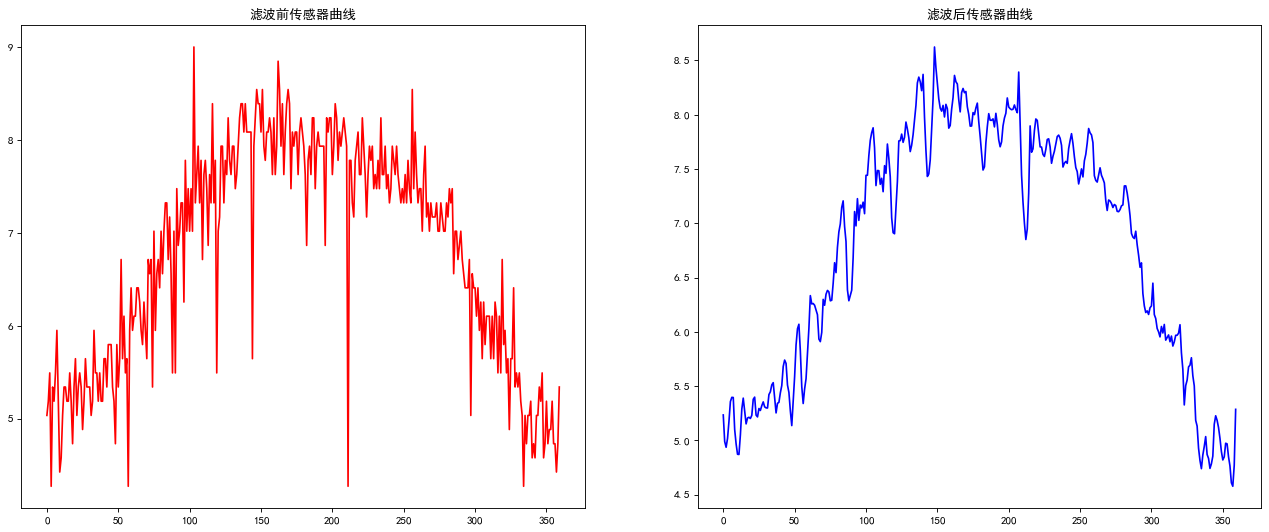

In [8]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
# 1.创建画布
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), dpi=80)

# 2.准备数据
x1 = range(360)
x2 = range(360)

dim1 = 0
dim2 = 0
y1 = selected_data[dim1][dim2]
y2 = waved_data[dim1][dim2]

# 3.绘制图像
axes[0].plot(x1, y1, color="r")
axes[1].plot(x2, y2, color="b")
axes[0].set_title("滤波前传感器曲线")
axes[1].set_title("滤波后传感器曲线")

plt.show()

### mRMR

In [9]:
# area特征
feature_area = scio.loadmat("../毕设/数据集/sensor大鼠数据/feature/feature4/feature_area_EP.mat")
feature_area = feature_area["feature_area_EP"]
print(feature_area.shape)

# 标准化
transfer = StandardScaler()
standard_feature_area = transfer.fit_transform(feature_area)
standard_feature_area.shape

(205, 31)


(205, 31)

In [10]:
import pymrmr
import pandas as pd
# 标签
feature_infect_label = scio.loadmat("../毕设/数据集/sensor大鼠数据/feature/feature4/LABEL_EP.mat")
feature_infect_label = np.reshape(feature_infect_label['infect_LABEL'],[205,])
pd_label = pd.Series(feature_infect_label, name="label")

# 数据
index = ["feature{}".format(i) for i in range(31)]
pd_feature_area = pd.DataFrame(standard_feature_area,columns=index)
pd_feature_area.insert(0,"label",pd_label)
pd_feature_area

,label,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,...,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30
0,1,-0.404168,0.371155,0.347843,-0.241666,1.338431,1.357442,0.891603,-0.332864,-0.391051,...,0.915513,-0.215575,2.353481,-0.404520,0.664713,0.224665,-0.557699,-0.324003,-0.048836,-0.285444
1,1,-0.279525,0.144705,0.073726,-0.198959,0.282148,0.790458,0.542656,-0.263530,-0.432549,...,0.853523,-0.186616,0.977150,-0.408277,0.669115,0.022778,-0.464009,-0.321365,-0.097880,0.316516
2,1,-0.287353,-0.371746,-0.315213,-0.397620,-0.374958,0.330530,0.064572,-0.336290,-0.449696,...,0.080372,-0.350627,0.096481,-0.555736,0.314800,-0.347962,-0.600610,-0.481995,-0.287207,-0.060203
3,1,-0.396112,-0.280107,-0.534360,-0.515516,-0.694980,0.048387,-0.256310,-0.395382,-0.458536,...,0.020947,-0.454017,-0.290110,-0.623304,-0.005086,-0.564437,-0.650842,-0.544449,0.005120,-0.251717
4,1,-0.452862,-0.460647,-0.657814,-0.583723,-0.805565,-0.108838,-0.437694,-0.415819,-0.460414,...,-0.123085,-0.513779,-0.487209,-0.661607,-0.226925,-0.667554,-0.690722,-0.596666,-0.132433,0.071075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,4,-0.744783,-0.688653,0.862309,0.793237,1.297987,0.426457,0.691589,0.529385,0.469878,...,1.368647,0.667101,0.904542,0.932003,0.481382,0.767056,0.869228,0.713606,-0.574234,-0.022872
201,4,-0.771931,-0.771778,0.304481,0.466413,0.125327,-0.224103,0.096091,0.356087,0.235530,...,0.529796,0.391275,-0.613628,0.579669,0.065257,0.192717,0.546797,0.400871,-0.736843,0.004643
202,4,-0.758651,-0.835472,-0.316732,-0.122835,-0.397533,-0.319890,-0.349570,-0.080920,-0.241226,...,0.400314,-0.143204,-0.598356,-0.118192,-0.054369,-0.367762,-0.142333,-0.167314,-0.041288,-0.313989
203,4,-0.795853,-1.027566,-0.796517,-0.558145,-0.729531,-0.599696,-0.703236,-0.347987,-0.485063,...,0.059336,-0.503513,-0.755537,-0.525132,-0.311452,-0.821172,-0.545091,-0.516878,0.418847,-0.316850


In [11]:
# mRMR特征选择
MID = pymrmr.mRMR(pd_feature_area,'MID',31)
MIQ = pymrmr.mRMR(pd_feature_area,'MIQ',31)

print("MID:",MID)
MID_index = np.zeros([31,], dtype = int)
for i in range(31):
    MID_index[i] = int(MID[i][7:])
print(MID_index)

print("\n")

print("MIQ:",MIQ)
MIQ_index = np.zeros([31,], dtype = int)
for i in range(31):
    MIQ_index[i] = int(MIQ[i][7:])
print(MIQ_index)

MID: ['feature19', 'feature1', 'feature25', 'feature0', 'feature12', 'feature5', 'feature16', 'feature18', 'feature30', 'feature4', 'feature14', 'feature15', 'feature17', 'feature23', 'feature13', 'feature21', 'feature8', 'feature20', 'feature29', 'feature27', 'feature11', 'feature28', 'feature7', 'feature6', 'feature24', 'feature3', 'feature26', 'feature9', 'feature22', 'feature10', 'feature2']
[19  1 25  0 12  5 16 18 30  4 14 15 17 23 13 21  8 20 29 27 11 28  7  6
 24  3 26  9 22 10  2]


MIQ: ['feature19', 'feature30', 'feature12', 'feature1', 'feature25', 'feature0', 'feature16', 'feature5', 'feature18', 'feature4', 'feature14', 'feature15', 'feature21', 'feature23', 'feature17', 'feature11', 'feature20', 'feature6', 'feature8', 'feature2', 'feature26', 'feature3', 'feature13', 'feature27', 'feature28', 'feature24', 'feature9', 'feature29', 'feature22', 'feature7', 'feature10']
[19 30 12  1 25  0 16  5 18  4 14 15 21 23 17 11 20  6  8  2 26  3 13 27
 28 24  9 29 22  7 10]


In [12]:
from numpy import *
def pca(dataMat, topNfeat = 999999):
    meanValues = mean(dataMat,axis=0) # 竖着求平均值，数据格式是m×n
    meanRemoved = dataMat - meanValues  # 0均值化  m×n维
    covMat = cov(meanRemoved,rowvar=0)  # 每一列作为一个独立变量求协方差  n×n维
    eigVals, eigVects = linalg.eig(mat(covMat)) # 求特征值和特征向量  eigVects是n×n维
    eigValInd = argsort(-eigVals)  # 特征值由大到小排序，eigValInd十个arrary数组 1×n维
    eigValInd = eigValInd[:topNfeat]  # 选取前topNfeat个特征值的序号  1×r维
    redEigVects = eigVects[:,eigValInd] # 把符合条件的几列特征筛选出来组成P  n×r维
    lowDDataMat = meanRemoved * redEigVects  # 矩阵点乘筛选的特征向量矩阵  m×r维 公式Y=X*P
    reconMat = (lowDDataMat * redEigVects.T) + meanValues  # 转换新空间的数据  m×n维
    return eigVals,eigValInd

In [13]:
val,val1 = pca(standard_feature_area)
a = np.sum(val)
b = val/a
b

array([6.11961810e-01, 1.18152990e-01, 7.32788290e-02, 4.51479025e-02,
       3.77481605e-02, 2.84660850e-02, 2.57889171e-02, 1.47439772e-02,
       1.34163331e-02, 9.14582122e-03, 5.97889017e-03, 4.71118608e-03,
       3.15836019e-03, 2.72943287e-03, 2.02086762e-03, 1.03080609e-03,
       8.30978209e-04, 5.39374807e-04, 3.90010601e-04, 3.51583373e-04,
       1.82282176e-04, 7.04340441e-05, 4.81104758e-05, 3.75570407e-05,
       2.84114726e-05, 1.65007953e-05, 9.92601216e-06, 5.83321721e-06,
       1.43335292e-06, 4.31836625e-06, 2.87664299e-06])

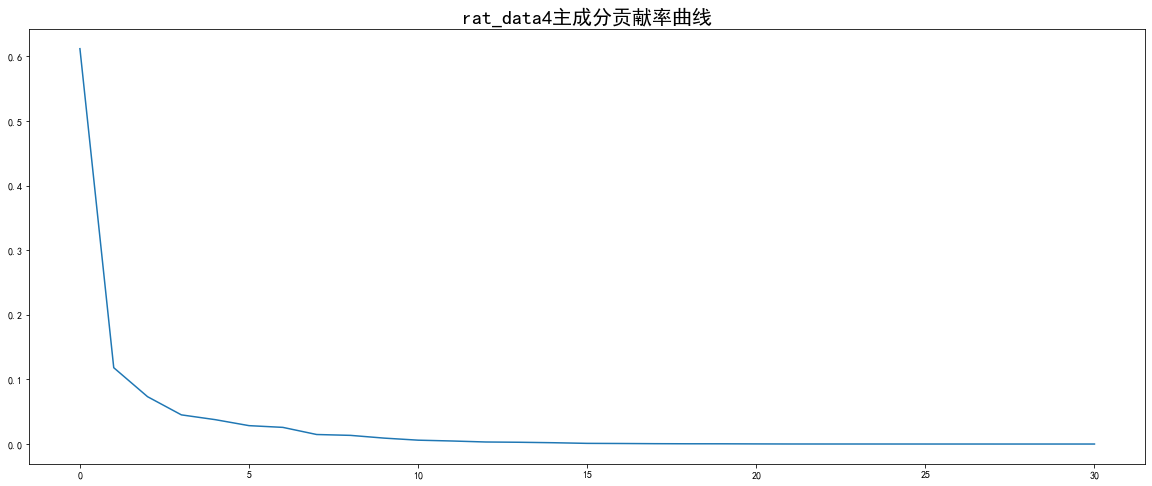

In [14]:
plt.figure(figsize=(20,8))
x = range(31)
plt.plot(x,b)
plt.title("rat_data4主成分贡献率曲线",fontdict={'family': 'sans-serif',
         'weight': 'normal',
         'size': 20,
         })
plt.show()

### 曲线和传感器筛选

In [15]:
final_data_sensor = waved_data[:,MIQ_index[0:15],:]
final_data = np.swapaxes(final_data_sensor,1,2)
final_data.shape

(209, 360, 15)

### 数据归一化

In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
transfer3 = MinMaxScaler()
minmax_data = np.zeros([209,360,15])
for i in range(209):
    minmax_data[i] = transfer3.fit_transform(final_data[i])
print(minmax_data.shape)

transfer4 = StandardScaler()
standard_data = np.zeros([209,360,15])
for i in range(209):
    standard_data[i] = transfer4.fit_transform(final_data[i])
print(standard_data.shape)

(209, 360, 15)
(209, 360, 15)


### 标签处理

In [17]:
# 获取老鼠标签
Label = scio.loadmat("../毕设/数据集/sensor大鼠数据/rat_data/data4/LABEL.mat")
rat_Label = Label["rat_LABEL"]
rat_Label = rat_Label.reshape(209)
rat_Label.shape

(209,)

In [18]:
# 获取感染标签
infect_Label = Label["infect_LABEL"]
infect_Label.shape

(209, 1)

In [19]:
# 获取trueLabel
true_Label = Label["trueLABEL"]
true_Label.shape

(41, 1)

### 转换为one hot编码

In [20]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(infect_Label)
OneHot_infect_Labels = enc.transform(infect_Label).toarray()
OneHot_infect_Labels.shape

(209, 4)

### LSTM网络

In [21]:
from tensorflow import keras
from keras.layers import Dense,LSTM, Dropout, Input, Lambda
from keras.models import Sequential, Model
from keras import initializers

# 回调函数,设置训练集准确率大于0.9停止
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.98):
      self.model.stop_training = True
callbacks = myCallback()

def output(X):
    return X

def lstm(train_data, train_label, test_data, test_label):
    # 参数初始化
    n_inputs = 15 #输入一行的长度
    max_time = 360 #行数
    lstm_units = 30 #隐层单元
    n_classes = 4 #4个分类
    
    # 均值为0，标准差为0.1的截断正态分布
    def truncated_normal():
        return initializers.TruncatedNormal(stddev=0.1)
    
    # 输入层
    input = Input(shape=([max_time, n_inputs]), name='input')
    
    # 三个返回值分别是 所有时间步的输出，最后时间步的输出，细胞状态all_hidden_state, last_hidden_state, state_c
    all_hidden_state, last_hidden_state, state_c = LSTM(units=lstm_units, activation='tanh', input_shape=[max_time, n_inputs], 
                                                        return_sequences=True, return_state=True)(input)
    # 最后时间步的输出再连接全连接层
    final_output = Dense(units=n_classes, kernel_initializer=truncated_normal(), activation='softmax', name='final_output')(last_hidden_state)
    model = Model([input], [final_output])
    
    # Adam梯度下降优化器
    optimizer = keras.optimizers.Adam(0.01)
    
    # 编译模型，损失函数为交叉熵损失
    model.compile(loss={'final_output': 'categorical_crossentropy'}, optimizer=optimizer, metrics=['accuracy'])
    
    # 模型训练，迭代次数为50
    history = model.fit({'input':train_data}, {'final_output':train_label}, epochs=100, verbose=0,callbacks=[callbacks])
#     print("Loss:", history.history['loss'])
    print("Accuracy:", history.history['accuracy'])
    print("Avg_Training_Acc:", np.array(history.history['accuracy']).mean())
    # 模型评估
    score = model.evaluate({'input':test_data}, {'final_output':test_label}, verbose=1)
    result = model.predict(test_data)
    print(result)
    print(model.metrics_names)
    print(score)
    return score[1], result

Using TensorFlow backend.


### 留一法交叉验证

In [22]:
lpgo = LeavePGroupsOut(n_groups=1)
total_score = []
final_result = []
rat = 0
index = 0
for (train, test) in lpgo.split(standard_data,groups=rat_Label):
    rat+=1
    print("rat%d" %(rat))
    
    # 获取数据
    train_data = standard_data[train]
    test_data = standard_data[test]
    
    # 获取标签
    train_label = OneHot_infect_Labels[train]
    test_label = OneHot_infect_Labels[test]
    
    # lstm
    score, result = lstm(train_data, train_label, test_data, test_label)
    
    total_score.append(score)
    
    # 对比true_LABEL
    max_value = np.zeros([len(test),], dtype=int)
    for i in range(len(test)):
        max_value[i] = np.argmax(result[i]) + 1
        
    # 获取出现次数最多的元素
    if (np.mean(np.equal(max_value, true_Label[index]).astype(int))==0.5):
        compare_result= np.array([1])
    else:
        count = np.bincount(max_value)
        common_value = np.argmax(count)
        compare_result = np.equal(common_value, true_Label[index]).astype(int)
    final_result.append(compare_result)
    
    index+=1
    
print("total_score:",total_score)
print("mean:",np.mean(total_score))
print("std:",np.std(total_score))
print("final_result:", np.mean(final_result))

rat1
Accuracy: [0.47058824, 0.57843137, 0.6372549, 0.6764706, 0.74509805, 0.76960784, 0.8088235, 0.8235294, 0.84313726, 0.8333333, 0.9019608, 0.877451, 0.85784316, 0.7794118, 0.8627451, 0.8872549, 0.877451, 0.89215684, 0.9019608, 0.9166667, 0.90686274, 0.95098037, 0.9460784, 0.9607843, 0.9411765, 0.9607843, 0.9705882, 0.96568626, 0.9852941]
Avg_Training_Acc: 0.8458419
5/5 [==============================] - 0s 16ms/step
[[9.69951510e-01 2.83660162e-02 4.32019850e-04 1.25041755e-03]
 [9.93720055e-01 4.45590401e-03 9.52958944e-05 1.72875763e-03]
 [9.94106889e-01 4.04109061e-03 1.07080945e-04 1.74500211e-03]
 [9.94672477e-01 3.91761633e-03 1.49831234e-04 1.26013323e-03]
 [8.51723999e-02 9.14237201e-01 2.37571483e-04 3.52848321e-04]]
['loss', 'accuracy']
[0.5022279024124146, 0.800000011920929]
rat2
Accuracy: [0.4019608, 0.5980392, 0.61764705, 0.6911765, 0.79901963, 0.7205882, 0.6960784, 0.8382353, 0.8235294, 0.8480392, 0.85784316, 0.82843137, 0.8333333, 0.8480392, 0.872549, 0.8186275, 0.852

Accuracy: [0.37560976, 0.5463415, 0.702439, 0.71707314, 0.69756097, 0.7902439, 0.81463414, 0.7853659, 0.7902439, 0.83902436, 0.86341465, 0.86341465, 0.8487805, 0.8341463, 0.89756095, 0.9170732, 0.9073171, 0.91219515, 0.91219515, 0.93658537, 0.9073171, 0.9317073, 0.9268293, 0.95609754, 0.9512195, 0.95609754, 0.94634145, 0.9170732, 0.9512195, 0.94634145, 0.94634145, 0.97073174, 0.9756098, 0.9804878]
Avg_Training_Acc: 0.85925394
4/4 [==============================] - 0s 20ms/step
[[8.4974378e-01 1.3988355e-01 3.2406410e-03 7.1319775e-03]
 [3.4352925e-01 6.4906788e-01 1.8405289e-03 5.5622910e-03]
 [5.2810799e-02 9.4542599e-01 1.2054134e-03 5.5783242e-04]
 [9.8239946e-01 1.4256599e-02 4.7026100e-04 2.8736664e-03]]
['loss', 'accuracy']
[1.6764544248580933, 0.5]
rat12
Accuracy: [0.42156863, 0.5588235, 0.6960784, 0.6960784, 0.6617647, 0.7352941, 0.7794118, 0.84313726, 0.7941176, 0.8186275, 0.8333333, 0.86764705, 0.8872549, 0.872549, 0.86764705, 0.88235295, 0.9117647, 0.9117647, 0.9166667, 0.92

Accuracy: [0.41666666, 0.627451, 0.6911765, 0.75980395, 0.76960784, 0.8137255, 0.8235294, 0.88235295, 0.872549, 0.8872549, 0.88235295, 0.8039216, 0.74509805, 0.86764705, 0.89215684, 0.89705884, 0.95098037, 0.9607843, 0.96568626, 0.92156863, 0.9313725, 0.872549, 0.8382353, 0.9264706, 0.92156863, 0.9313725, 0.9558824, 0.9558824, 0.9754902, 0.9754902, 0.99509805]
Avg_Training_Acc: 0.86163825
5/5 [==============================] - 0s 16ms/step
[[0.0011625  0.04497474 0.9301301  0.02373268]
 [0.07812577 0.79101187 0.11527243 0.01558995]
 [0.09353312 0.83341694 0.06064399 0.01240597]
 [0.013583   0.6427622  0.29754755 0.04610725]
 [0.00300351 0.07731302 0.8510701  0.06861339]]
['loss', 'accuracy']
[1.3040382862091064, 0.6000000238418579]
rat22
Accuracy: [0.4039409, 0.49753696, 0.6699507, 0.67487687, 0.74876845, 0.7192118, 0.773399, 0.81280786, 0.8522167, 0.6896552, 0.817734, 0.85714287, 0.8374384, 0.9014778, 0.9162561, 0.90640396, 0.9162561, 0.9408867, 0.9162561, 0.92610836, 0.9359606, 0.935

Accuracy: [0.44117647, 0.5980392, 0.70098037, 0.73039216, 0.79901963, 0.8186275, 0.8088235, 0.7745098, 0.7647059, 0.8039216, 0.78431374, 0.8627451, 0.8627451, 0.8872549, 0.8872549, 0.86764705, 0.9166667, 0.9313725, 0.9362745, 0.9362745, 0.89705884, 0.92156863, 0.9460784, 0.9264706, 0.95098037, 0.9411765, 0.95098037, 0.9754902, 0.98039216]
Avg_Training_Acc: 0.84837735
5/5 [==============================] - 0s 16ms/step
[[0.00381886 0.79570794 0.11803258 0.08244058]
 [0.01502309 0.16749322 0.7791279  0.03835584]
 [0.00795626 0.20313625 0.74070925 0.0481982 ]
 [0.0104861  0.0847095  0.85625815 0.04854622]
 [0.00162617 0.2368381  0.19228835 0.56924736]]
['loss', 'accuracy']
[0.8980928659439087, 0.6000000238418579]
rat32
Accuracy: [0.45320198, 0.5862069, 0.6600985, 0.6600985, 0.6896552, 0.79310346, 0.8226601, 0.8325123, 0.8374384, 0.8078818, 0.8226601, 0.82758623, 0.85714287, 0.84236455, 0.8719212, 0.89162564, 0.8866995, 0.91133004, 0.8965517, 0.90640396, 0.9211823, 0.9507389, 0.90640396, 0

Accuracy: [0.4019608, 0.74509805, 0.73039216, 0.7205882, 0.75980395, 0.7058824, 0.76960784, 0.8382353, 0.84313726, 0.8480392, 0.89215684, 0.89705884, 0.92156863, 0.9313725, 0.9166667, 0.8627451, 0.90686274, 0.85784316, 0.88235295, 0.92156863, 0.9411765, 0.90686274, 0.9313725, 0.9362745, 0.9460784, 0.9558824, 0.9558824, 0.9460784, 0.9705882, 0.96568626, 0.9313725, 0.9411765, 0.9313725, 0.96568626, 0.98039216]
Avg_Training_Acc: 0.8731093
5/5 [==============================] - 0s 16ms/step
[[2.7572989e-04 1.0666778e-02 9.8640984e-01 2.6476660e-03]
 [3.1077683e-03 9.3511147e-03 9.4752353e-01 4.0017571e-02]
 [5.9446541e-04 1.7875912e-02 9.6972501e-01 1.1804680e-02]
 [1.2227456e-03 2.0642299e-02 9.6090871e-01 1.7226221e-02]
 [7.5577917e-03 2.3863468e-02 8.4719472e-02 8.8385922e-01]]
['loss', 'accuracy']
[3.5553104877471924, 0.20000000298023224]
total_score: [0.800000011920929, 1.0, 1.0, 0.20000000298023224, 0.800000011920929, 1.0, 1.0, 1.0, 0.6000000238418579, 0.6666666865348816, 0.5, 0.4000